In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
from urllib.request import urlopen
import certifi
import json
import math
import QuantLib as ql

plt.rcParams["figure.figsize"] = (16,9)

In [2]:
# list of exception 
class FinLabException(Exception):
    def __init__(self, message):
        self.message = message

**Value at Risk (VaR)** can be calulate using 3 methods (Bloomberg Terminal)
* Historical Simulation
* Parametric VaR
* Monte Carlo Simulation (Geometric brownian motion)

**Import data from yfinance**

In [3]:
port_ticker = ['PNC','MSFT','TSLA','AAPL','TMUS','URI','WBD','WDC']
port_weight = np.array([1/len(port_ticker)]*len(port_ticker)) # create equal weight
start, end = dt.datetime(2021,12,31),  dt.datetime(2023,1,1)
n_day = 5 # hold for 5 days

In [4]:
def get_VaR( port_ticker,port_weight,start,end,n_day, conf_lv, method = 'parametric',n_simulation = 100000):
    method_type = {'parametric','historical','monte-carlo'}
    if method not in method_type: raise FinLabException("method_type_not_exist: {}".format(method))
    df = yf.download(port_ticker, start, end)['Adj Close']
    ret = df.pct_change().dropna()
    conf_lv = 1 - conf_lv
    if method == 'parametric':
        return norm.ppf(conf_lv,ret.mean() @ port_weight,np.sqrt(port_weight.T @ ret.cov() @ port_weight)) * np.sqrt(n_day)
    elif method == 'historical':
        port_ret = (ret*port_weight).sum(axis = 1)
        return np.percentile(port_ret,conf_lv*100,interpolation = 'lower') * n_day
    else:
        dt = 1/252
        mean_ret = ret.mean().values
        vol = ret.std().values
        n_assets = len(port_ticker)
        np.random.seed(0)
        # geometric brownian simulation
        asset_prices = np.zeros((n_simulation, n_day + 1, n_assets))
        asset_prices[:, 0, :] = df.iloc[-1].values  # initial prices
        for i in range(n_assets):
            for j in range(1, n_day + 1):
                rand = np.random.standard_normal(n_simulation,)
                asset_prices[:, j, i] = asset_prices[:, j - 1, i] * np.exp((mean_ret[i] - 0.5 * vol[i] ** 2) * dt
                                                                    + vol[i] * np.sqrt(dt) * rand)
        port_val = (asset_prices * port_weight).sum(axis=2)
        port_ret = (port_val[:, -1] - port_val[:, 0]) / port_val[:, 0]

        # Calculate VaR using geometric Brownian motion simulation
        return np.percentile(port_ret, conf_lv * 100,interpolation='lower') * n_day

In [5]:
conf_lv = 0.95
get_VaR( port_ticker,port_weight,start,end,n_day, conf_lv, method = 'parametric',n_simulation = 100000)

[*********************100%***********************]  8 of 8 completed


-0.07817488622790467

In [6]:
get_VaR(port_ticker,port_weight,start,end,n_day, conf_lv, method = 'historical',n_simulation = 100000)

[*********************100%***********************]  8 of 8 completed


-0.1822898482620699

In [7]:
get_VaR(port_ticker,port_weight,start,end,n_day, conf_lv, method = 'monte-carlo',n_simulation = 100000)

[*********************100%***********************]  8 of 8 completed


-0.012612375847688196

**Credit Valuation Adjustment (CVA)**

$CVA = (1-R) \int{DF(t) EE(t) dPD_t}$
* R: Recovery Rate
* T: portfolio matrity of all deals
* DF(t): discount factor at time t
* EE(t): the expected exposure at time t
* PD(t): the default probability

**Approximate using BASEL III formula** (approximating default probability [or survival probability ] as exp(-ST/(1-R)))

$CVA= (1-R) \sum  \frac{EE^{*}_{T_{i}}+EE^{*}_{T_{i-1}}}{2} (e^{-\frac{ST_{i-1}}{1-R}}-e^{-\frac{ST_{i}}{1-R}})^+$

* $EE^{*}$: discounted Expected exposure of portfolio

**White Hull model for future yield curve simulations**
* $\gamma_t=f_t(0)+\frac{\sigma^2}{2a}(1-e^{-at})^2$

In [8]:
# modified from PriceDerivatives.com

In [9]:
# import
from  QuantLib import *
import numpy as np
from math import *
from matplotlib import pyplot as plt

In [10]:
# function
def A(t,T): # floting rate payer
    forward = crvToday.forwardRate(t, t,Continuous, NoFrequency).rate()
    value = B(t,T)*forward - 0.25*sigma*B(t,T)*sigma*B(t,T)*B(0.0,2.0*t)
    return exp(value)*crvToday.discount(T)/crvToday.discount(t)

def B(t,T): # fixed rate payer
    return (1.0-exp(-a*(T-t)))/a

def gamma(t):
        forwardRate =crvToday.forwardRate(t, t, Continuous, NoFrequency).rate()
        temp = sigma*(1.0 - exp(-a*t))/a
        return (forwardRate + 0.5*temp*temp)

def gamma_v(t):
    res=np.zeros(len(t))
    for i in range(len(t)):
        res[i]=gamma(t[i])
    return res

In [11]:
# set market conditions
Nsim=100
a=0.1
sigma=0.02

todaysDate=Date(30,12,2023)
Settings.instance().evaluationDate=todaysDate
crvToday=FlatForward(todaysDate,0.02,Actual360())

r0=forwardRate =crvToday.forwardRate(0,0, Continuous, NoFrequency).rate()
months=range(1,12*5,1)
sPeriods=[str(month)+"m" for month in months]
Dates=[todaysDate]+[todaysDate+Period(s) for s in sPeriods]
T=[0]+[Actual360().yearFraction(todaysDate,Dates[i]) for i in range(1,len(Dates))]
T=np.array(T)
rmean=r0*np.exp(-a*T)+ gamma_v(T) -gamma(0)*np.exp(-a*T)

np.random.seed(1)
stdnorm = np.random.standard_normal(size=(Nsim,len(T)-1))

rmat=np.zeros(shape=(Nsim,len(T)))
rmat[:,0]=r0

**Simulate var and mean**
* $dr_t=(\theta_t-ar_t)dt+\sigma dW_t$ :rmat
* $E(r_t|r_s)=r_se^{-a(t-s)}+\gamma_t-\gamma_se^{-a(t-s)}$ : mean
* $Var(r_t|r_s)=\frac{\sigma^2}{2a}(1-e^{-2a(t-s)})$ : var

In [12]:
# simulate mean and var or r_t given r_s
for iSim in range(Nsim):
    for iT in range(1,len(T)):
        mean=rmat[iSim,iT-1]*exp(-a*(T[iT]-T[iT-1]))+gamma(T[iT])-gamma(T[iT-1])*exp(-a*(T[iT]-T[iT-1]))
        var=0.5*sigma*sigma/a*(1-exp(-2*a*(T[iT]-T[iT-1])))
        rmat[iSim,iT]=mean+stdnorm[iSim,iT-1]*sqrt(var)

startDate=Date(30,12,2023)

crvMat= [ [ 0 for i in range(len(T)) ] for iSim in range(Nsim) ]
npvMat= [ [ 0 for i in range(len(T)) ] for iSim in range(Nsim) ]

**Calculate White Hull discont factor**


$P_{->T}(t)=A(t,T)e^{-B(t,T)r_t}$ : crvDisconts


In [13]:
for row in crvMat:
    row[0]=crvToday

for iT in range(1,len(T)):
    for iSim in range(Nsim):
        crvDate=Dates[iT]
        crvDates=[crvDate]+[crvDate+Period(k,Years) for k in range(1,21)]
        crvDiscounts=[1.0]+[A(T[iT],T[iT]+k)*exp(-B(T[iT],T[iT]+k)*rmat[iSim,iT]) for k in range(1,21)]
        crvMat[iSim][iT]=DiscountCurve(crvDates,crvDiscounts,Actual360(),TARGET())


In [14]:
#indexes definitions
forecastTermStructure = RelinkableYieldTermStructureHandle()
index = Euribor(Period("6m"),forecastTermStructure)

#swap 1 definition
maturity = Date(30,12,2028)
fixedSchedule = Schedule(startDate, maturity,Period("6m"), TARGET(),ModifiedFollowing,ModifiedFollowing,DateGeneration.Forward, False)
floatingSchedule = Schedule(startDate, maturity,Period("6m"),TARGET() ,ModifiedFollowing,ModifiedFollowing,DateGeneration.Forward, False)
swap1 = VanillaSwap(VanillaSwap.Receiver, 5000000,fixedSchedule,0.0475 , Actual360(),floatingSchedule, index, 0,Actual360())
# revieved 10,000,000 usd fixed

In [15]:
for iT in range(len(T)):
    Settings.instance().evaluationDate=Dates[iT]
    allDates= list(floatingSchedule)
    fixingdates=[index.fixingDate(floatingSchedule[iDate]) for iDate in range(len(allDates)) if index.fixingDate(floatingSchedule[iDate])<=Dates[iT]]
    if fixingdates:
        for date in fixingdates[:-1]:
            try:index.addFixing(date,0.0)
            except:pass
        try:index.addFixing(fixingdates[-1],rmean[iT])
        except:pass
    discountTermStructure = RelinkableYieldTermStructureHandle()
    swapEngine = DiscountingSwapEngine(discountTermStructure)
    swap1.setPricingEngine(swapEngine)

    for iSim in range(Nsim):
        crv=crvMat[iSim][iT]
        discountTermStructure.linkTo(crv)
        forecastTermStructure.linkTo(crv)
        npvMat[iSim][iT]=swap1.NPV()

In [16]:
npvMat=np.array(npvMat)
npvMat[npvMat<0]=0
EE=np.mean(npvMat,axis=0)

**Calculate CAV**

$CVA = (1-R) \int{DF(t) EE(t) dQ_t}$



CVA= 78182.87708528904


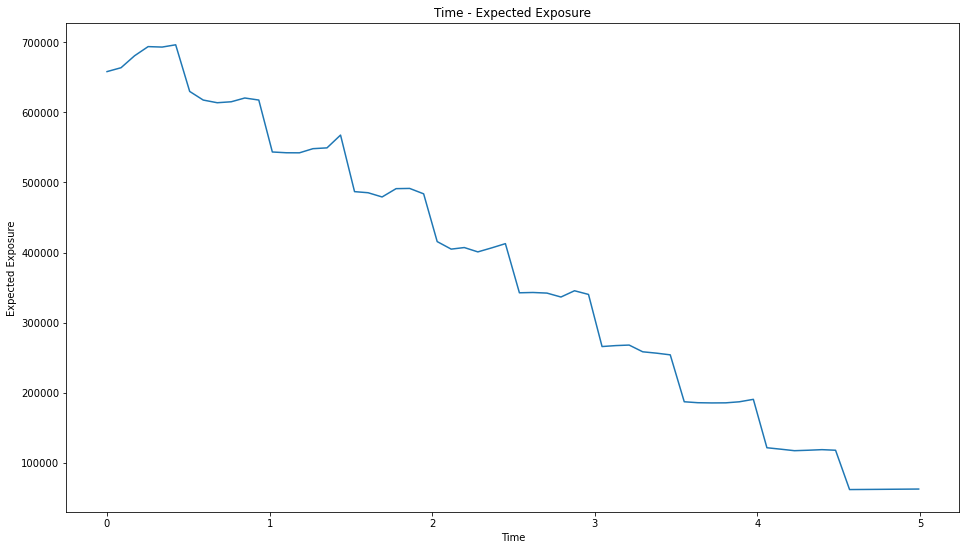

In [17]:
S=0.05 #constant CDS spread
R=0.4  #Recovery rate 40%

sum=0
#calculate CVA
for i in range(len(T)-1):
    sum=sum+0.5*(EE[i]*crvToday.discount(T[i])+EE[i+1]*crvToday.discount(T[i+1]))*(exp(-S*T[i]/(1.0-R))-exp(-S*T[i+1]/(1.0-R)))
CVA=(1.0-R)*sum

print ("\nCVA=",CVA)

plt.plot(T,EE)
plt.title("Time - Expected Exposure")
plt.xlabel("Time")
plt.ylabel("Expected Exposure")
plt.show()
# print ("\nEE\n",npvMat)

* take one interest rate swap with 5M notiontal notional value and receving 4.70 (FFR rate), TARGET calendar with 10 years maturity.

**Expected Loss (EL)** = Exposure at default(EAD) x Probability of default(PD) x Loss given default (LGD) 

In [18]:
# Geting financial Data from APIs request
def get_jsonparsed_data(url):
    response = urlopen(url, cafile=certifi.where())
    data = response.read().decode("utf-8")
    return json.loads(data)

url = ("https://financialmodelingprep.com/api/v3/balance-sheet-statement/AAPL?limit=400&apikey=32d2976a52769cc61cb61ac9d08a667e")
balance_sheet_statement_df = pd.DataFrame(get_jsonparsed_data(url)).set_index('date')
balance_sheet_statement_df.sort_index(inplace=True)
balance_sheet_statement_df.head()

C:\Users\SARAN\AppData\Local\Temp\ipykernel_13064\2703275735.py:3: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


,symbol,reportedCurrency,cik,fillingDate,acceptedDate,calendarYear,period,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,...,totalStockholdersEquity,totalEquity,totalLiabilitiesAndStockholdersEquity,minorityInterest,totalLiabilitiesAndTotalEquity,totalInvestments,totalDebt,netDebt,link,finalLink
date,,,,,,,,,,,,,,,,,,,,,
1985-09-30,AAPL,USD,0000320193,1985-09-30,1985-09-29 20:00:00,1985,FY,337000000,0,337000000,...,550500000,550500000,936200000,0,936200000,0,0,-337000000,,
1986-09-30,AAPL,USD,0000320193,1986-09-30,1986-09-29 20:00:00,1986,FY,576200000,0,576200000,...,694100000,694100000,1160100000,0,1160100000,0,0,-576200000,,
1987-09-30,AAPL,USD,0000320193,1987-09-30,1987-09-29 20:00:00,1987,FY,565100000,0,565100000,...,836500000,836500000,1477900000,0,1477900000,0,0,-565100000,,
1988-09-30,AAPL,USD,0000320193,1988-09-30,1988-09-29 20:00:00,1988,FY,545700000,0,545700000,...,1003400000,1003400000,2082100000,0,2082100000,0,315000000,-230700000,,
1989-09-30,AAPL,USD,0000320193,1989-09-30,1989-09-29 20:00:00,1989,FY,438300000,0,438300000,...,1485700000,1485700000,2743900000,0,2743900000,0,56800000,-381500000,,


**Total Assets plot: AAPL**

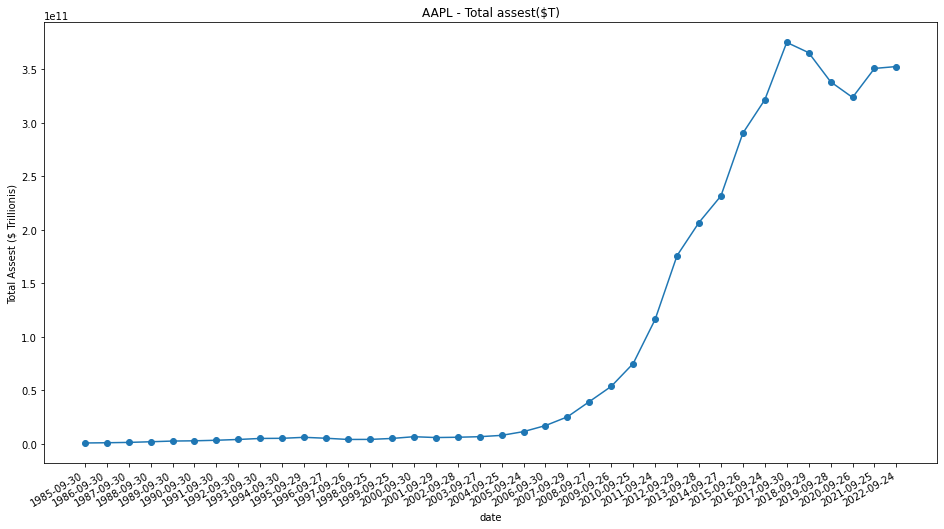

In [19]:
plt.plot(balance_sheet_statement_df['totalAssets'])
plt.scatter(balance_sheet_statement_df.index,balance_sheet_statement_df['totalAssets'])
plt.xlabel("date")
plt.ylabel("Total Assest ($ Trillionis)")
plt.title("AAPL - Total assest($T)")
plt.gcf().autofmt_xdate()
plt.show()

**Total Assests : Last 10-years**

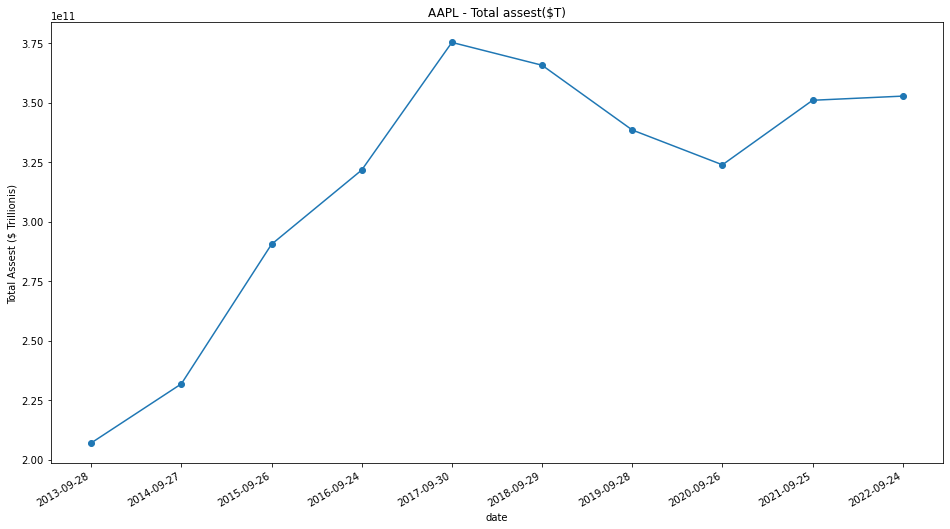

In [20]:
plt.plot(balance_sheet_statement_df['totalAssets'][-10:])
plt.scatter(balance_sheet_statement_df.index[-10:],balance_sheet_statement_df['totalAssets'][-10:])
plt.xlabel("date")
plt.ylabel("Total Assest ($ Trillionis)")
plt.title("AAPL - Total assest($T)")
plt.gcf().autofmt_xdate()
plt.show()

**Plot Liabilities: AAPL (Last 20 years)**

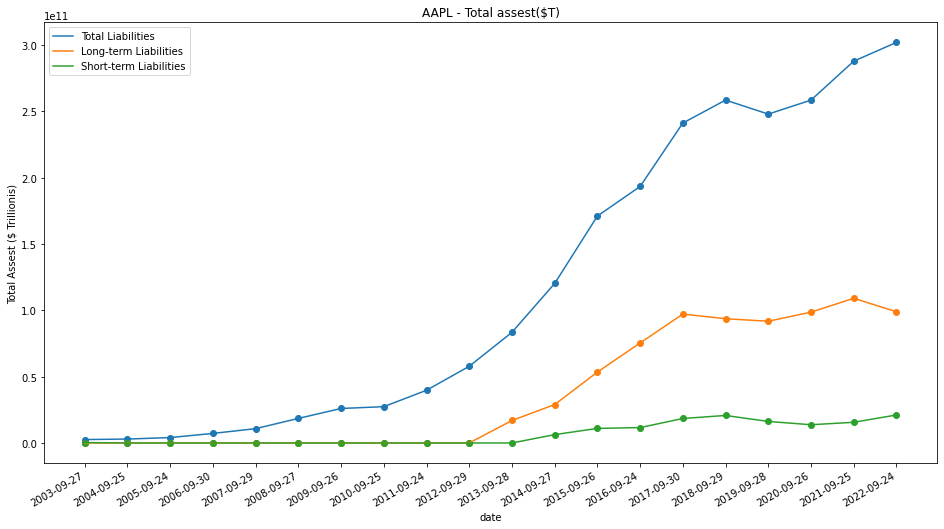

In [21]:
plt.plot(balance_sheet_statement_df['totalLiabilities'][-20:],label = "Total Liabilities")
plt.scatter(balance_sheet_statement_df.index[-20:],balance_sheet_statement_df['totalLiabilities'][-20:])

plt.plot(balance_sheet_statement_df['longTermDebt'][-20:],label = "Long-term Liabilities")
plt.scatter(balance_sheet_statement_df.index[-20:],balance_sheet_statement_df['longTermDebt'][-20:])

plt.plot(balance_sheet_statement_df['shortTermDebt'][-20:],label = "Short-term Liabilities")
plt.scatter(balance_sheet_statement_df.index[-20:],balance_sheet_statement_df['shortTermDebt'][-20:])

plt.xlabel("date")
plt.ylabel("Total Assest ($ Trillionis)")
plt.title("AAPL - Total assest($T)")
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

**Calculate Distance to Default (DD)**

In [22]:
# Calculate PD using last five year data

firm_value = balance_sheet_statement_df['totalAssets'][-1]
# given default point if the total assest drop more than 25%
default_point =  firm_value*0.75
expected_firm_ret = balance_sheet_statement_df['totalAssets'][-5:].pct_change().mean()*100
firm_vol = balance_sheet_statement_df['totalAssets'][-5:].pct_change().std()*100
n_years = 1
dd = -(math.log(firm_value/default_point)+(expected_firm_ret - (firm_vol**2)/2)*n_years)/firm_vol*np.sqrt(n_years)
dd

3.5063092906795545